In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import struct
import array
import os
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator

# Athena++ modules
# import athena_read
import athena_read_select
import h5py
import netCDF4
import xarray as xr

In [151]:
filename = 'disk.out1.00100.athdf'

In [152]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [153]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 24 24]
1480314
2772
[5]
[168  72 576]
[0.4      2.5      1.003814]
[1.3962634 1.7453293 1.       ]
[0.        6.2831855 1.       ]
628.31854
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [154]:
data['rho'].shape

(588, 1152, 560)

In [155]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()
phipos=400

In [156]:
phi, theta, r = np.meshgrid(data['x3v'], data['x2v'], data['x1v'], indexing='ij')

In [157]:
rp, thetap, phip = 1, np.pi / 2, np.pi

In [158]:
rho = data['rho']

In [159]:
vr = data['vel1']
vtheta = data['vel2']
vphi = data['vel3']

In [160]:
# recentering the coordinates to make them planet-centered
r_new = np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi))
phi_new = np.arctan2(r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi) + rp)
theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_76330/245351492.py:4: RuntimeWarning: invalid value encountered in arccos
  theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))


In [161]:
from itertools import product

In [162]:
def searchsorted(l, x):
    for i in l:
        if i >= x: break
    # return l.index(i)
    return np.where(l == i)[0][0]

def trilinear_interpolation(x_volume, y_volume, z_volume, volume, x_needed, y_needed, z_needed):
    """
    Trilinear interpolation (from Wikipedia)

    :param x_volume: x points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param y_volume: y points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param x_volume: z points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param volume:   volume
    :type crack_type: list or numpy.ndarray
    :param x_needed: desired x coordinate of volume
    :type crack_type: float
    :param y_needed: desired y coordinate of volume
    :type crack_type: float
    :param z_needed: desired z coordinate of volume
    :type crack_type: float

    :return volume_needed: desired value of the volume, i.e. volume(x_needed, y_needed, z_needed)
    :type volume_needed: float
    """
    # dimensinoal check
    if np.shape(volume) != (len(x_volume), len(y_volume), len(z_volume)):
        raise ValueError(f'dimension mismatch, volume must be a ({len(x_volume)}, {len(y_volume)}, {len(z_volume)}) list or numpy.ndarray')
    # check of the indices needed for the correct control volume definition
    i = searchsorted(x_volume, x_needed)
    j = searchsorted(y_volume, y_needed)
    k = searchsorted(z_volume, z_needed)
    # control volume definition
    control_volume_coordinates = np.array(
        [[x_volume[i - 1], y_volume[j - 1], z_volume[k - 1]], [x_volume[i], y_volume[j], z_volume[k]]])
    xd = (np.array([x_needed, y_needed, z_needed]) - control_volume_coordinates[0]) / (control_volume_coordinates[1] - control_volume_coordinates[0])
    # interpolation along x
    c2 = [[0, 0], [0, 0]]
    for m, n in product([0, 1], [0, 1]):
        c2[m][n] = volume[i - 1][j - 1 + m][k - 1 + n] * (1 - xd[0]) + volume[i][j - 1 + m][k - 1 + n] * xd[0]
    # interpolation along y
    c1 = [0, 0]
    c1[0] = c2[0][0] * (1 - xd[1]) + c2[1][0] * xd[1]
    c1[1] = c2[0][1] * (1 - xd[1]) + c2[1][1] * xd[1]
    # interpolation along z
    volume_needed = c1[0] * (1 - xd[2]) + c1[1] * xd[2]
    return volume_needed

In [163]:
trilinear_interpolation(data['x3v'], data['x2v'], data['x1v'], vr, 2.942857, np.pi/2, 0.950568)

0.04394557381057864

In [164]:
np.where(np.isclose(data['x3v'],2.942857))

(array([2]),)

In [165]:
np.where(np.isclose(data['x2v'],np.pi/2))

(array([576]),)

In [166]:
np.where(np.isclose(data['x1v'],0.950568))

(array([123]),)

In [167]:
vr[2,576,123]

0.043930076

In [19]:
nanmask = np.isnan(theta_new)

In [20]:
from scipy.interpolate import griddata

In [18]:
# stacked_coords = np.stack((phi_new[~nanmask],theta_new[~nanmask],r_new[~nanmask])).reshape(3,-1).T

In [19]:
from scipy import interpolate

In [21]:
# N=100
# phi_points = np.linspace(0,2*np.pi, N)
# theta_points = np.linspace(0,np.pi,N)
# r_points = np.ones(N) * Rh

# grid_phi, grid_theta, grid_r = np.meshgrid(phi_points,theta_points,r_points, indexing="ij")

In [23]:
# interpolator = interpolate.RegularGridInterpolator(stacked_coords, values=rho[~nanmask].flatten(), fill_value=None)

In [24]:
# griddata(np.stack((phi_new[~nanmask],theta_new[~nanmask],r_new[~nanmask])).reshape(3,-1).T, rho[~nanmask].flatten(), (grid_phi, grid_theta, grid_r), method='cubic')

In [25]:
# def linear_interp(value1, value2, point1, point2, point_needed):
#     y = value1 + (point_needed-point1) * (value2 - value1) / (point2 - point1)
#     return y

In [168]:
# planet-centered velocities
vr_new = 1 / 2 * 1 / r_new * (2 * r * vr + 2 * rp * (vr * np.sin(theta) * np.cos(phi) + vtheta * np.cos(theta) * np.cos(phi) - vphi*np.sin(phi)))
vtheta_new = r_new * 1 / np.sqrt(r ** 2 * np.sin(theta) ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) \
* ((vtheta * np.sin(theta) - vr * np.cos(theta)) + r * np.cos(theta) / (r ** 2+rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) * \
   (r * vr + vr * rp * np.sin(theta) * np.cos(phi) + rp * vtheta * np.cos(theta) * np.cos(phi) - rp * vphi * np.sin(phi)))
vphi_new = r_new * np.sin(theta_new) * 1 / (r ** 2 * np.sin(theta) ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) * \
(vphi + rp * (vr * np.sin(theta) * np.sin(phi) + vtheta * np.cos(theta) * np.sin(phi) + vphi * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_76330/894961704.py:3: RuntimeWarning: divide by zero encountered in divide
  vtheta_new = r_new * 1 / np.sqrt(r ** 2 * np.sin(theta) ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) \


In [26]:
trilinear_interpolation(phi_new[:,0,0], theta_new[0,:,0], r_new[0,0,:], rho, -0.7845075, 2.1386833, 0.2764957)

0.002318479284631188

In [27]:
np.where(np.isclose(theta_new[0,:,0],2.1386833))

(array([1150]),)

In [28]:
np.where(np.isclose(phi_new[:,0,0],-0.7845075))

(array([572]),)

In [29]:
np.where(np.isclose(r_new[0,0,:],0.2764957))

(array([13]),)

In [30]:
rho[572,1150,13]

0.0020119993

In [169]:
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

In [170]:
dist = np.sqrt((x + 1) ** 2 + y ** 2 + z ** 2) - Rh

In [171]:
indices = np.nonzero((np.abs(dist)<3e-4) & (~np.isnan(theta_new)))

In [17]:
phi_new[indices]

array([ 1.483333 ,  1.493759 ,  1.5041916, ..., -1.4937503, -1.5041828,
       -1.5146161], dtype=float32)

In [188]:
N=100
phi_points = np.linspace(0, 2 * np.pi, N) 
theta_points = np.linspace(np.arccos(-1), np.arccos(1), N)[::-1]
r_points = np.ones(N) * Rh

interp_den = []


In [136]:
r_points_mesh, theta_points_mesh, phi_points_mesh = np.meshgrid(r_points, theta_points, phi_points, indexing='ij')

In [137]:
x_points = r_points_mesh * np.sin(theta_points_mesh) * np.cos(phi_points_mesh)
y_points = r_points_mesh * np.sin(theta_points_mesh) * np.sin(phi_points_mesh)
z_points = r_points_mesh * np.cos(theta_points_mesh)

In [138]:
x_points_new = x_points - 1

In [139]:
r_points_new = np.sqrt(x_points_new ** 2 + y_points ** 2 + z_points ** 2)
theta_points_new = np.arctan2(y_points, x_points_new)
phi_points_new = np.arccos(z_points / r_points_new)

In [141]:
phi_new[indices]

array([ 1.483333 ,  1.493759 ,  1.5041916, ..., -1.4937503, -1.5041828,
       -1.5146161], dtype=float32)

In [173]:
np.arccos(1/np.sqrt(1+Rh**2))

0.06684356303478946

In [187]:
theta_points = np.linspace(data['x2v'][0]+0.2,data['x2v'][-1]-0.2, N) 
phi_points = np.linspace(data['x3v'][0]+0.2,data['x3v'][-1]-0.2, N)
r_points = np.linspace(data['x1v'][0]+0.2,data['x1v'][-1]-0.2, N)

In [189]:
phi_points_mesh, theta_points_mesh, r_points_mesh = np.meshgrid(phi_points,theta_points,r_points, indexing='ij')

In [199]:
for i in range(N):
    for j in range(N):
        for k in range(N):
            interp_den.append(trilinear_interpolation(data['x3v'], data['x2v'], data['x1v'], rho, phi_points[i], theta_points[j], r_points[k]))

In [73]:
lon = np.pi - phi_points_new % (2*np.pi)
lat = np.pi/2 - theta_points_new % np.pi

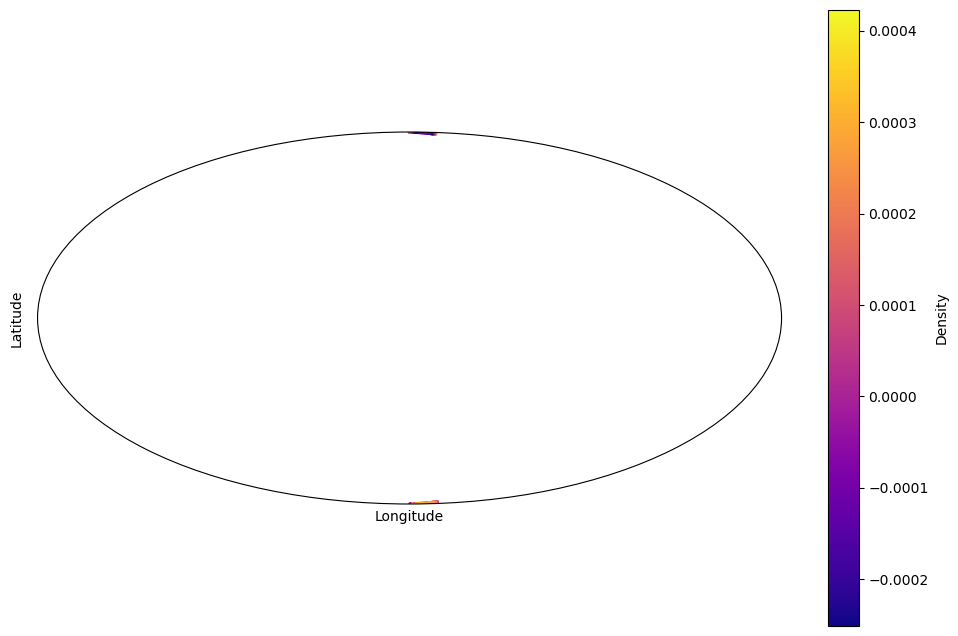

In [86]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.scatter(lon, lat, c=np.array(interp_den), s=3, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Density')
plt.show()

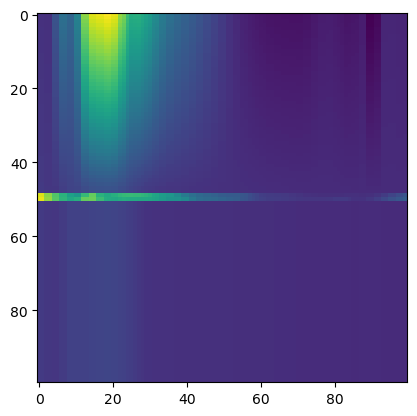

In [32]:
plt.imshow(interp_den[-1])

In [33]:
lon = np.pi - phi_points 
lat = np.pi/2 - theta_points 

In [57]:
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic

In [58]:
nside = 100
order = 'NESTED'

In [59]:
hp = HEALPix(nside=nside, order=order) 